# PCA

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [8]:
class PCA:
    def __init__(self, n_components, whiten, random_state=41, gram_iter=20):
        self.n_components = n_components
        self.whiten = whiten
        self.gram_iter = gram_iter

    def covariance(self,X):
        n_samples = X.shape[0]
        cov = np.dot(X.T, X) / (n_samples - 1)
        return cov

    def whitening(self, X):
        if self.whiten:
            std = np.std(X, axis=0)
            std[std == 0] = 1
            whitened_data = X / std  # Whitening 처리
        else:
            whitened_data = X        # Whitening 아닌 경우

        return whitened_data         # whitened_data 반환

    def gram_schmidt(self, data):
        samples, features = data.shape
        cov = np.zeros((samples, features))
        for i in range(features):
          vec = data[:, i]
          for j in range(i):
            proj = np.dot(cov[:, j], vec) * cov[:, j]
            vec = vec - proj
          cov[:, i] = vec / np.linalg.norm(vec)

        return cov

    def eig(self, cov):
        for _ in range(self.gram_iter):
          Q = self.gram_schmidt(cov)
          R = np.dot(Q.T, cov)
          A = np.dot(R, Q)

        eigvalues = np.zeros(A.shape[0])
        for i in range(A.shape[0]):
          eigvalues[i] = A[i,i]

        eigvectors = Q

        return eigvalues, eigvectors

    def fit(self, data):
        if self.whiten:
          self.mean = np.mean(data, axis=0)
          data_normalized = data - self.mean
        else:
          self.mean = np.mean(data, axis=0)
          data_normalized = data - self.mean

        data_normalized = self.whitening(data_normalized)
        cov = self.covariance(data_normalized)
        eigvalues, eigvectors = self.eig(cov)
        sorted_indices = np.argsort(eigvalues)[::-1]
        self.eigvalues_sorted = eigvalues[sorted_indices]
        eigvectors_sorted = eigvectors[:, sorted_indices]
        self.components_ = eigvectors_sorted[:, :self.n_components]
        pca_output = np.dot(data_normalized, self.components_)


        return pca_output



In [3]:
people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)
image_shape = people.images[0].shape
print("dataset keys        : ", people.keys())
print("dataset.images shape: ", people.images.shape)
print("dataset.data shape  : ", people.data.shape)
print("dataset.target shape: ", people.target.shape)

dataset keys        :  dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
dataset.images shape:  (1140, 62, 47)
dataset.data shape  :  (1140, 2914)
dataset.target shape:  (1140,)


In [9]:
pca = PCA(200, False)
n_component_data = pca.fit(people.data)
pca_w = PCA(200, True)
n_component_data_w = pca_w.fit(people.data)
X_train, X_test, y_train, y_test = train_test_split(n_component_data, people.target, test_size=0.25, random_state=41)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(n_component_data_w, people.target, test_size=0.25, random_state=41)

# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier as knc

In [11]:
knn = knc(n_neighbors=1)
knn_w = knc(n_neighbors=1)

In [12]:
knn.fit(X_train, y_train)
knn_w.fit(X_train_w, y_train_w)

KNeighborsClassifier(n_neighbors=1)

In [13]:
y_pred = knn.predict(X_test)
y_pred_w = knn_w.predict(X_test_w)

# Results
#### -F1 score를 각 채점 항목 별로 출력하면 됩니다

In [19]:
from sklearn.metrics import f1_score

In [16]:
print(f"Naive PCA: {f1_score(y_test, y_pred, average='weighted')}\nWhitening PCA: {f1_score(y_test_w, y_pred_w, average='weighted')}")

Naive PCA: 0.5900654655328842
Whitening PCA: 0.6200705222471983


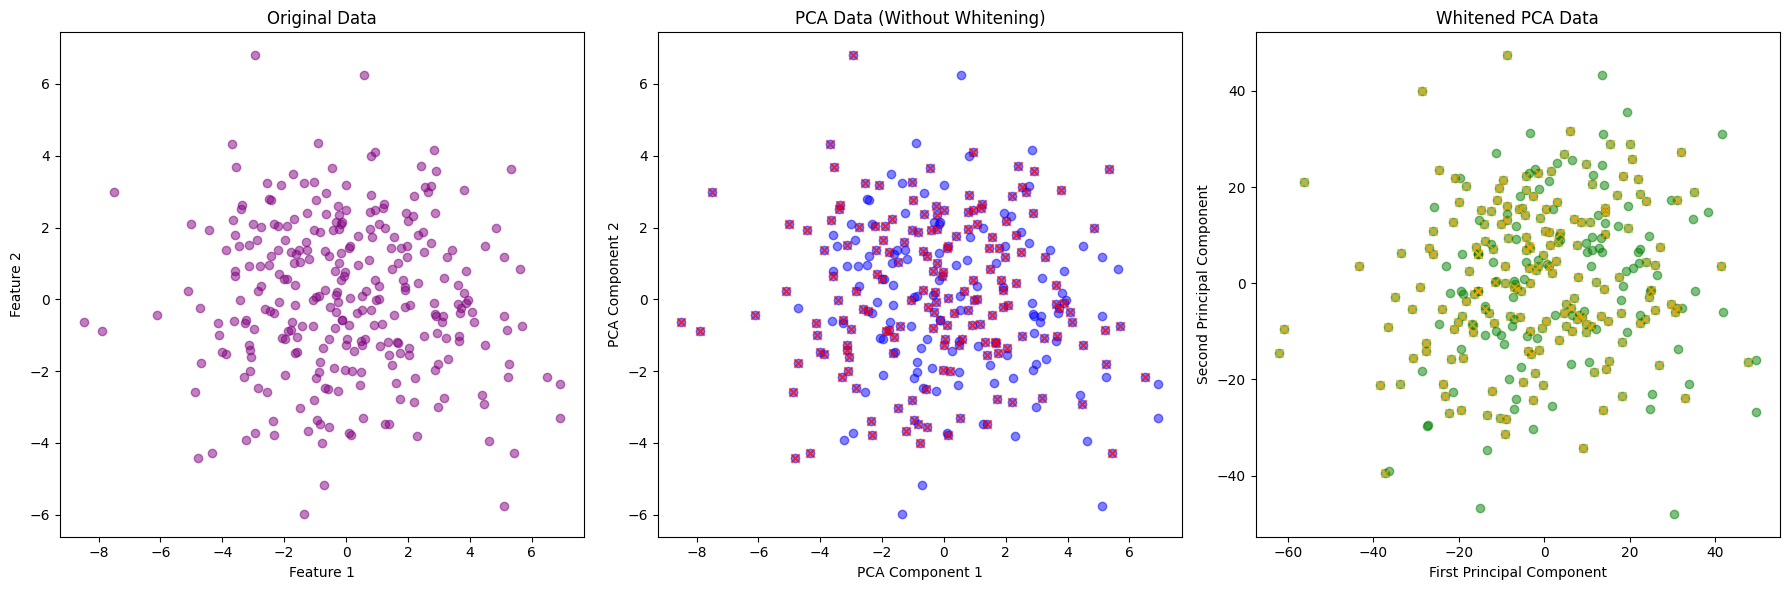

In [33]:
# 결과 그래프
def plot_knn_results_with_centroids(X_test, y_true, y_pred, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))

    classes = np.unique(y_true)
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    markers = ['o', 's', '^', 'D', 'P', 'X']

    for i, class_label in enumerate(classes):
        plt.scatter(X_test[y_true == class_label, 0], X_test[y_true == class_label, 1],
                    color=colors[i], label=f'Class {class_label} (True)', alpha=0.5, edgecolor='k')
        plt.scatter(X_test[y_pred == class_label, 0], X_test[y_pred == class_label, 1],
                    marker='x', color=colors[i], label=f'Class {class_label} (Pred)', alpha=0.8)

        class_center = np.mean(X_test[y_true == class_label], axis=0)
        plt.scatter(class_center[0], class_center[1], color='black', marker='*', s=200, edgecolor='k', label=f'Center {class_label}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 서브플롯으로 결과 시각화
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 원본 데이터
axs[0].scatter(X_test[:, 0], X_test[:, 1], color='purple', alpha=0.5)
axs[0].set_title('Original Data')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

# PCA 데이터 (화이트닝 미적용)
axs[1].scatter(X_test[:, 0], X_test[:, 1], color='blue', alpha=0.5)
axs[1].scatter(X_test[:, 0][y_pred == y_test], X_test[:, 1][y_pred == y_test], marker='x', color='red', alpha=0.7)
axs[1].set_title('PCA Data (Without Whitening)')
axs[1].set_xlabel('PCA Component 1')
axs[1].set_ylabel('PCA Component 2')

# PCA 데이터 (화이트닝 적용)
axs[2].scatter(X_test_w[:, 0], X_test_w[:, 1], color='green', alpha=0.5)
axs[2].scatter(X_test_w[:, 0][y_pred_w == y_test_w], X_test_w[:, 1][y_pred_w == y_test_w], marker='x', color='orange', alpha=0.7)
axs[2].set_title('Whitened PCA Data')
axs[2].set_xlabel('First Principal Component')
axs[2].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.show()
